In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import random

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

0.0037780525408761534
1665


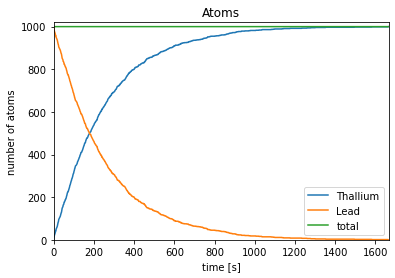

In [26]:
tau=3.052*60

NTl=1000
NPb=0

time=0
p=1-2**(-1/tau)
print(p)
listNP=[]
listTL=[]
tot=[]
while NPb<1000 :
    time=time+1
    for i in range(NTl):
        l=np.random.uniform(0,1)
        if l<p:
            NTl=NTl-1
            NPb+=1
    listNP.append(NPb)
    listTL.append(NTl)
    tot.append(NPb+NTl)

        
    
x=[i for i in range(0,time)]
print(time)
plt.plot(x, listNP, label = 'Thallium')
plt.plot(x, listTL, label = 'Lead')
plt.plot(x, tot, label = 'total')
plt.legend()
plt.axis([0, time, 0, 1020])
plt.ylabel('number of atoms')
plt.xlabel('time [s]')
plt.title('Atoms');

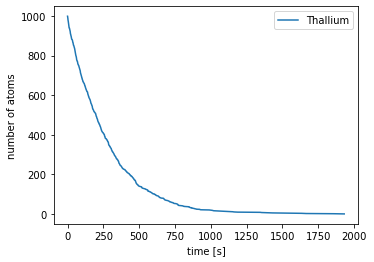

In [27]:
def pdf(t, tau = tau):
    return 2**(-t/tau)*np.log(2)/tau

def inverse(z, tau = tau):
    return (-tau/np.log(2)*np.log(1-z))

time = 1000
t_tot = np.arange(0,time,1)

n_Tl = 1000
n_Pb = 0

l_Tl = []
l_Pb = []


for a in range(0,n_Tl,1):
    t = inverse(np.random.uniform(0,1))    
    l_Tl.append(t)

l_Tl = np.sort(np.array(l_Tl))

plt.figure(figsize=(12,4))
plt.subplot(121)

plt.plot(l_Tl, range(999,-1,-1), label = 'Thallium')

plt.legend()
plt.ylabel('number of atoms')
plt.xlabel('time [s]')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [15]:
Z = 79
e2 = 2.88 
E = 7.7 
a0 = 52918 
sig = a0/100
N = 10**6

def scatter(b):
    return (Z * e2)/(E * b)

b = [ np.sqrt(random.gauss(0, sig)**2 + random.gauss(0, sig)**2) for i in range(N)]
c = [scatter(i) for i in b]
def angle(x):
    return 2*np.arctan(x)

t = np.array([angle(i) for i in c])

angles = t[(t > (np.pi/2))]
print(' Fraction of particles that "bounce back":',angles.shape[0]/N)
#print(angles.shape[0]/N)

 Fraction of particles that "bounce back": 0.001551


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2
N = 10000

n = 10
areas = []

for i in range(n):
    x = 2*np.random.uniform(0,1,N)
    y = np.random.uniform(0,1,N)
    dots = np.array([f(x) for x in x])
    p = y[y<dots]
    area = 2/N * p.shape[0]
    areas.append(area)

print('The mean is ', np.mean(areas))
print('The error ', np.std(areas))

The mean is  1.44744
The error  0.006177248578453


In [6]:
x = 2*np.random.uniform(0,1,N)
dots = np.array([f(x) for x in x])

area = 2* np.sum(dots)/N

std = 2* np.std(y)/np.sqrt(N)

print('The area is ', area)
print('The error is', std)

The area is  1.446634613410629
The error is 0.00576820730221514


Using the second method, we can obtain a smaller error

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [7]:
N = 100000
def f(x,y):
    z = x**2 + y**2
    if (z <= 1):
        return 1
    else:
        return 0  
    
x = np.random.uniform(-1,1,N)
y = np.random.uniform(-1,1,N)
dots = np.array([f(x,y) for x,y in zip(x,y)])
area = 4/N * np.sum(dots)
print('The area is:', area)

The area is: 3.14724


In [23]:
def f(par):
    z = 0
    for i in par:
        z += i**2  
    if (z <= 1):
        return 1
    else:
        return 0

Dim = 10
X = np.random.uniform(-1,1,size = (N,Dim)) 
dots = np.array([f(x) for x in X]) 

hypervolume = 2**10 * np.sum(dots)/N
print('The hypervolume of the 10D hypersphere is:',hypervolume)


The hypervolume of the 10D hypersphere is: 2.53952


The exact hypervolume of a 10D sphere is $$ \frac{\pi^5}{120}=2.550$$

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [9]:
N = 100000

def func(x):
    return x**(-1/2)/(np.exp(x) + 1) 
def w(x):
    if (x > 0):
        return 1/np.sqrt(x)
def inv(x):
    return x*x/4
    
W = inv(np.random.uniform(0,2,N))

a = np.array([func(i) for i in W ])
b = np.array([w(i) for i in W ])

I = 2 * np.sum( a/b )/N
print('The value of the integral is:',I)

The value of the integral is: 0.8395051828653569
